# Graph Theoretical Analysis on EPM Mossy Cell Data for DRD73

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import SigProc
from analysis.graph_analysis_utils import NeuronNetwork
from analysis.analysis_utils import FeatureExtractor
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell

In [2]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/EPM")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
2. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM2_drd87.csv
3. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
4. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
5. full path of: Raw_EPM_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv
6. full path of: behavior_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv
7. full path of: behavior_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv
8. full path of: Raw_EPM_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv


In [4]:
drd73_data = pd.read_csv(raw_files[3], header=None)
drd73_data = FeatureExtractor.downsample_dataframe(drd73_data, 2)
_, auc_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(drd73_data, 2, 0.5, 0.2, 10)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

behavior_df = pd.read_csv(raw_files[4], header=None)
drd73_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, behavior_col_names=beh_cols)

# Only leave the neuron numbers to save space when plotting the networks
drd73_fe.cell_transients_df.columns = [i for i in range(1, len(drd73_fe.cell_transients_df.columns)+1)]

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [5]:
def get_neuron_positions(neuron_network, coordinates_df):
    pos = dict()

    for neuron in neuron_network.neurons:
        if neuron not in pos:
            pos[neuron] = (coordinates_df.loc[neuron, :]["x"], -coordinates_df.loc[neuron, :]["y"])
            
    return pos

## DRD73's network for the *entire* duration of the EPM experiment.

You did not provide a neuron position dictionary, so the Spring Layout algorithm will be used to plot the network


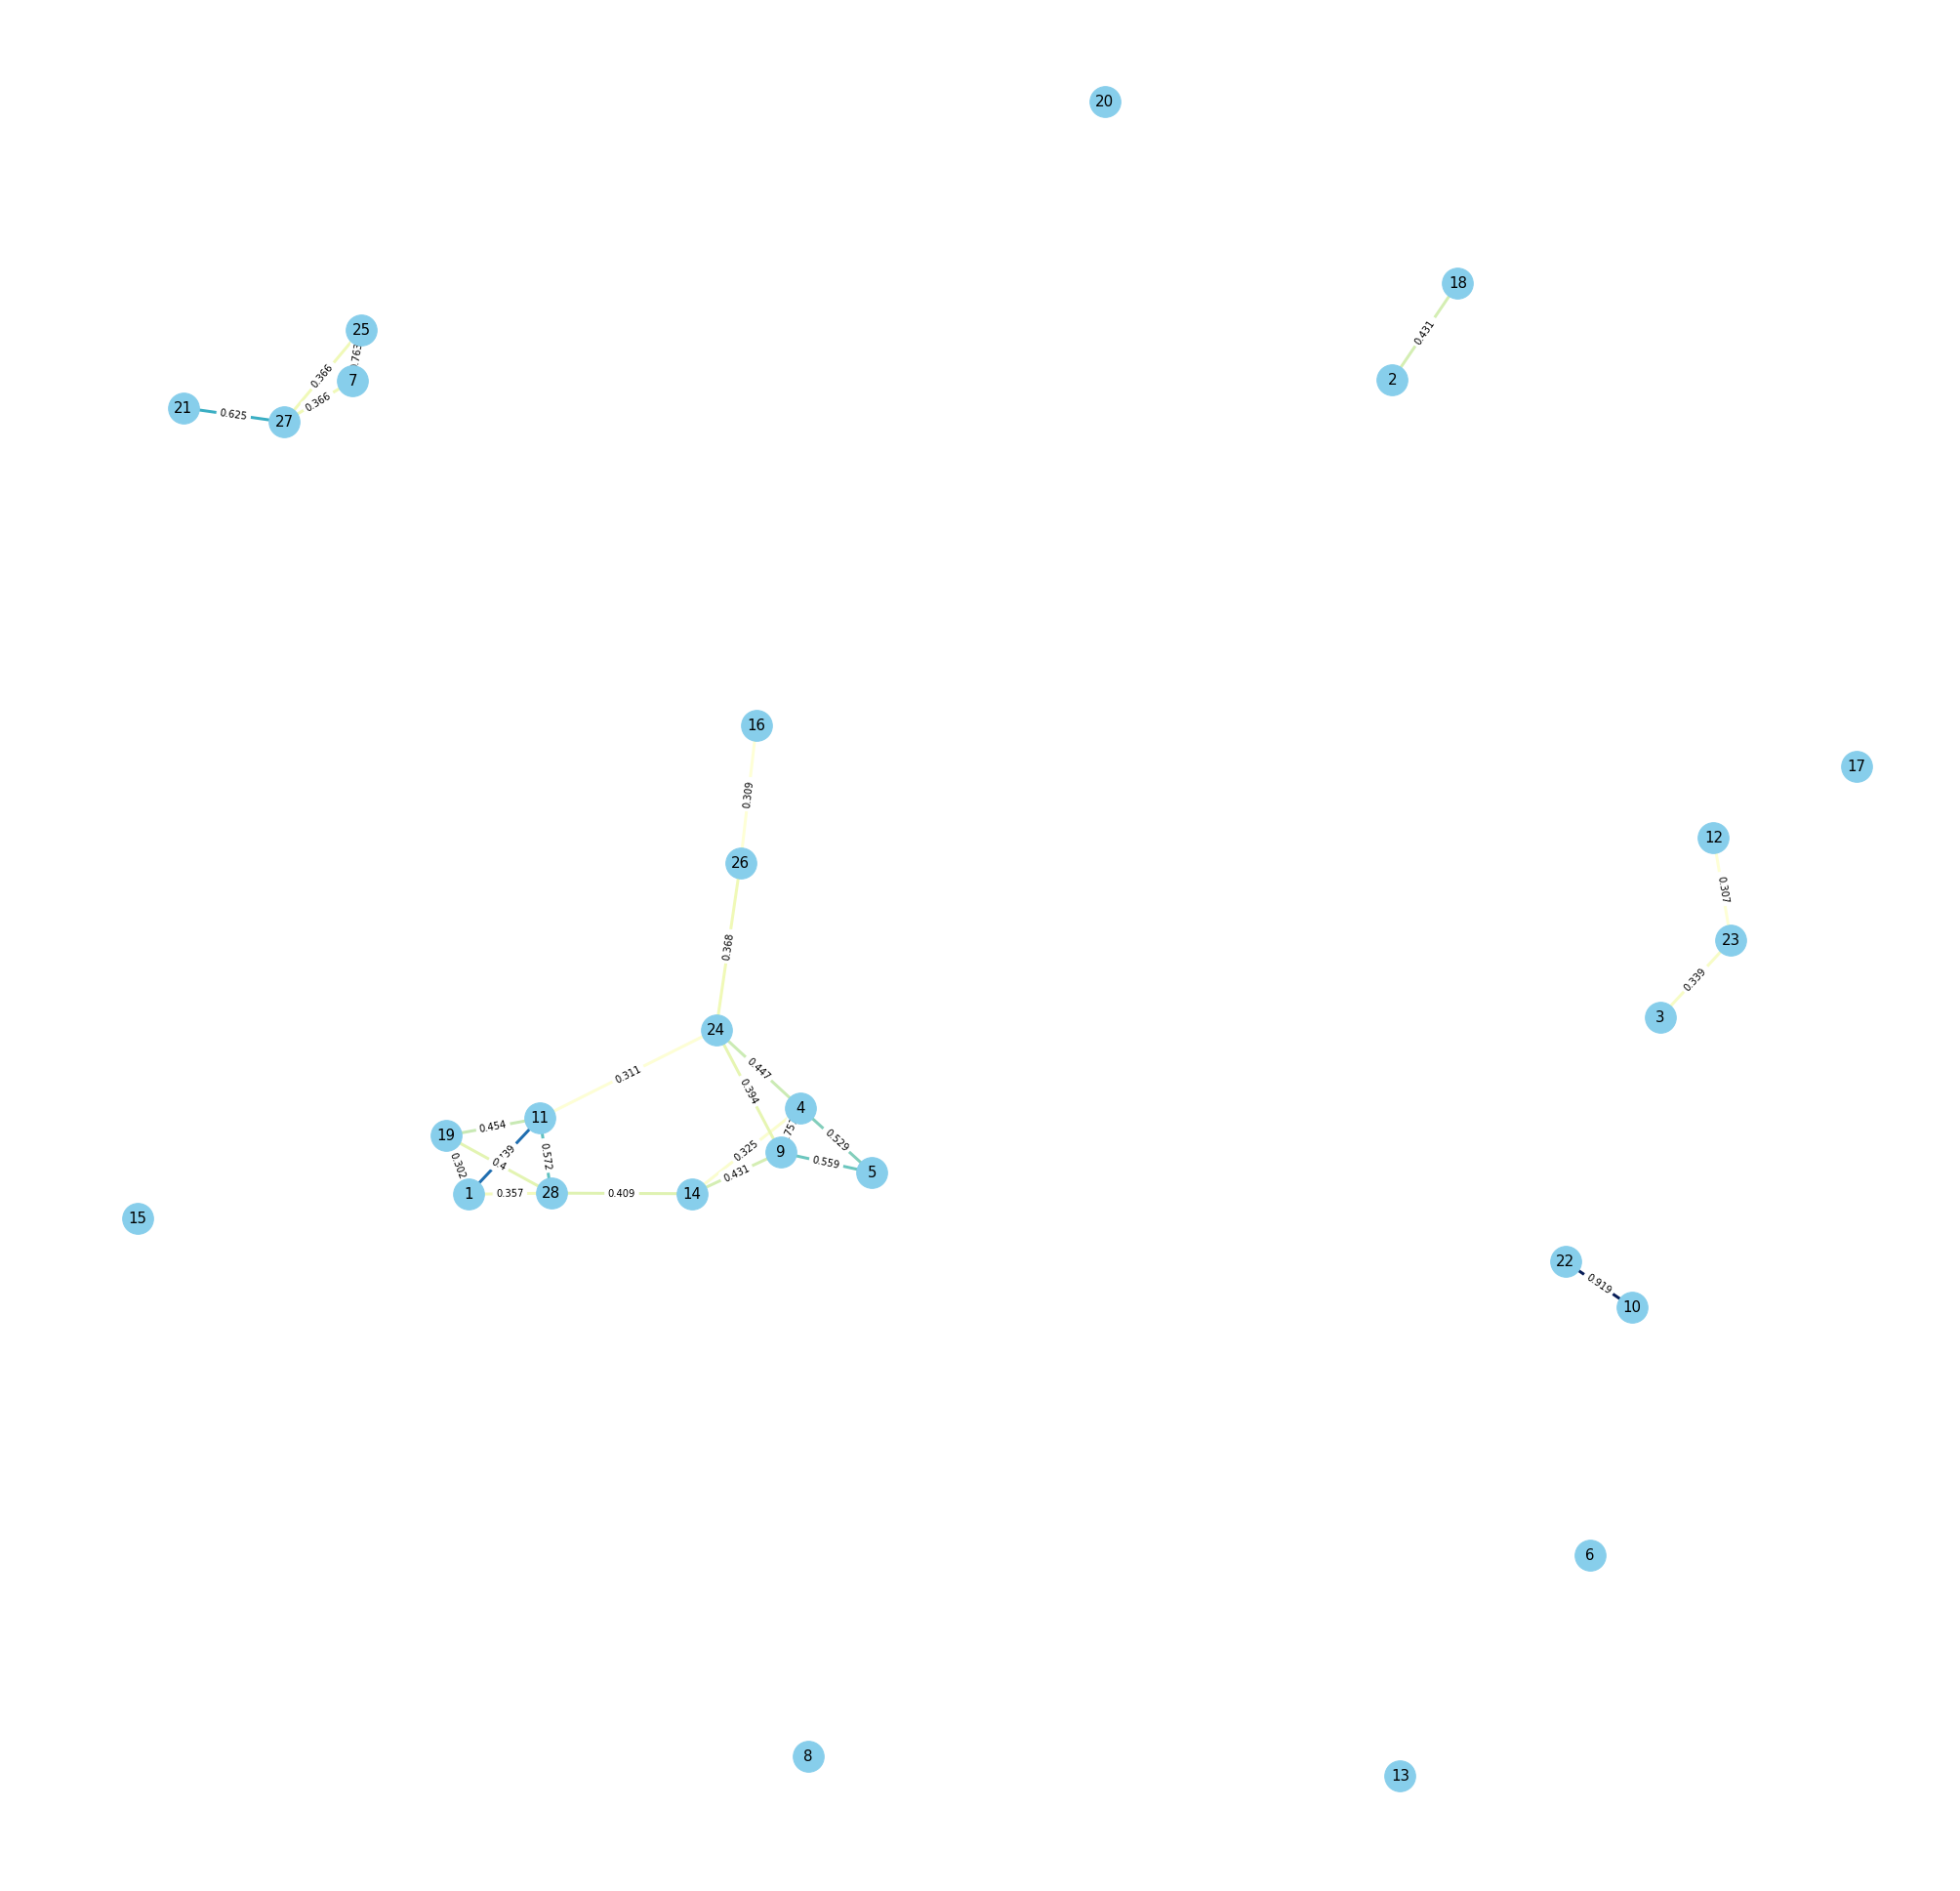

In [6]:
drd73_total_graph = NeuronNetwork(drd73_fe.cell_transients_df)
drd73_total_graph.plot(node_color="skyblue", figsize=(35, 35), node_size=1000)

## DRD73's network during the `OpenArms` of the EPM experiment.

You did not provide a neuron position dictionary, so the Spring Layout algorithm will be used to plot the network


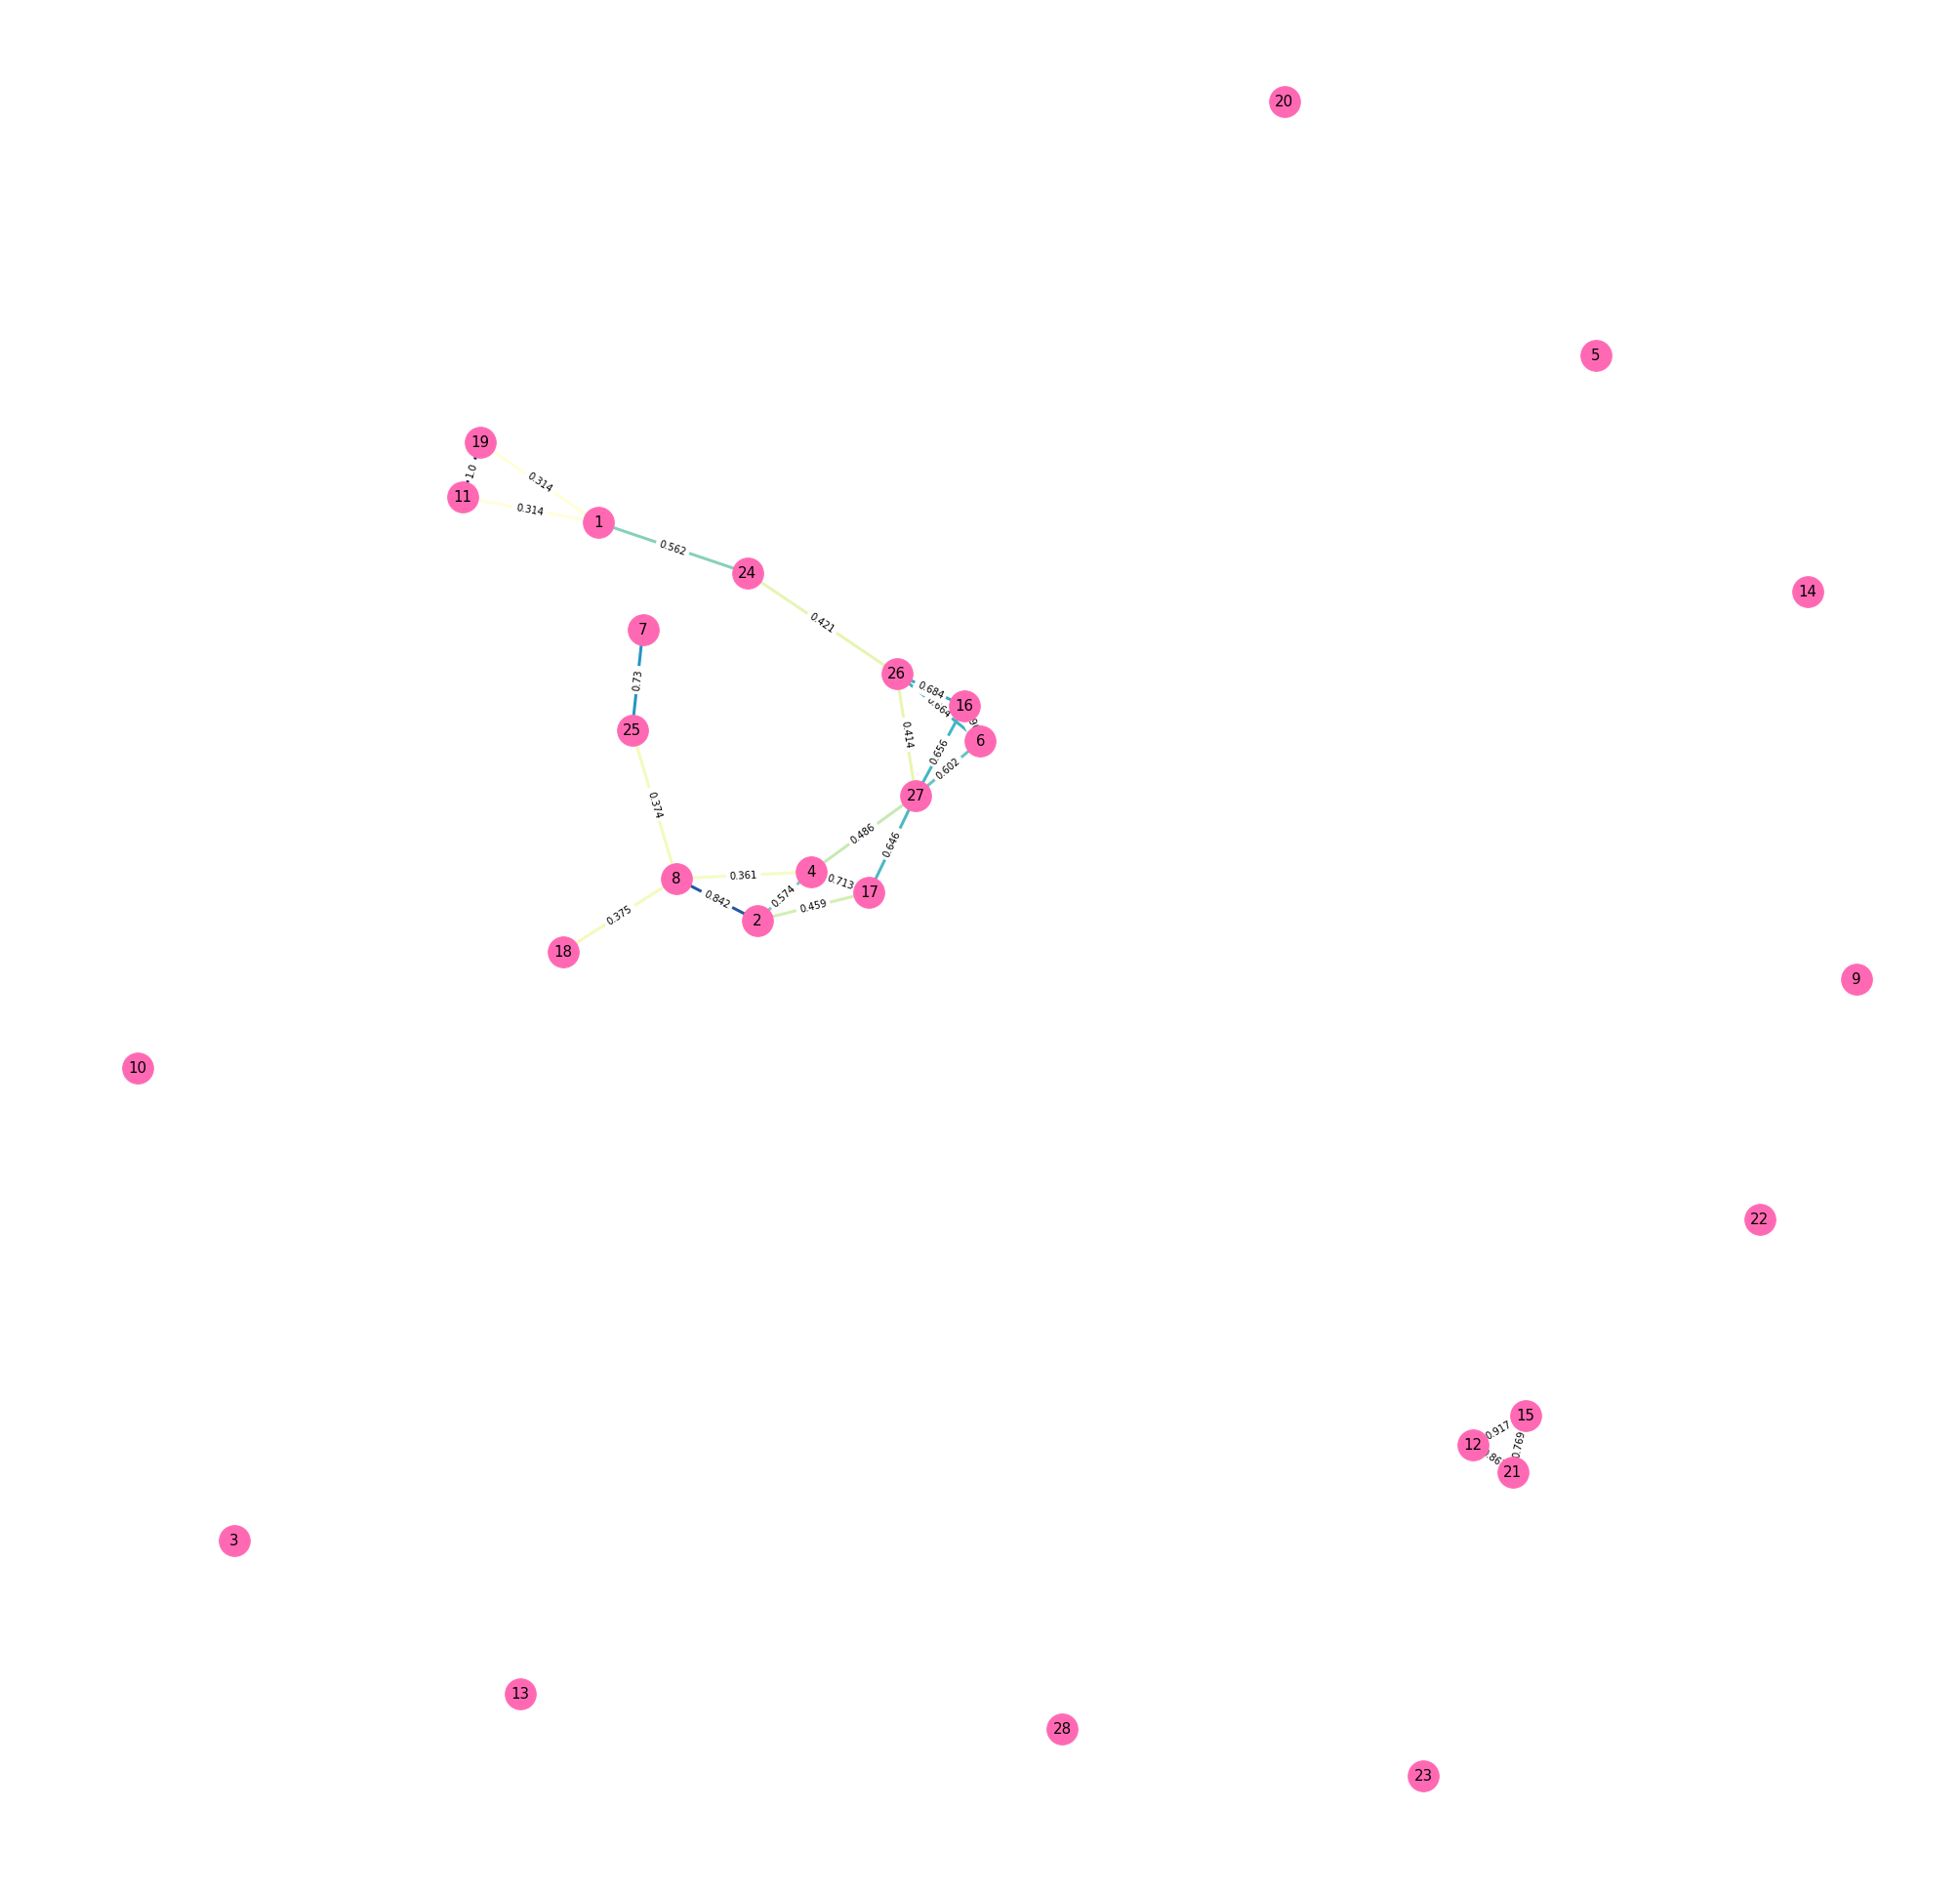

In [7]:
open_arms_indices = drd73_fe.neuron_concated_behavior.loc[drd73_fe.neuron_concated_behavior["OpenArms_centerpoint"] != 0].index
drd73_open_arms_graph = NeuronNetwork(drd73_fe.cell_transients_df.iloc[open_arms_indices])
drd73_open_arms_graph.plot(node_color="hotpink", figsize=(35, 35), node_size=1000)

## DRD77's network during the `ClosedArms` of the EPM experiment.

You did not provide a neuron position dictionary, so the Spring Layout algorithm will be used to plot the network


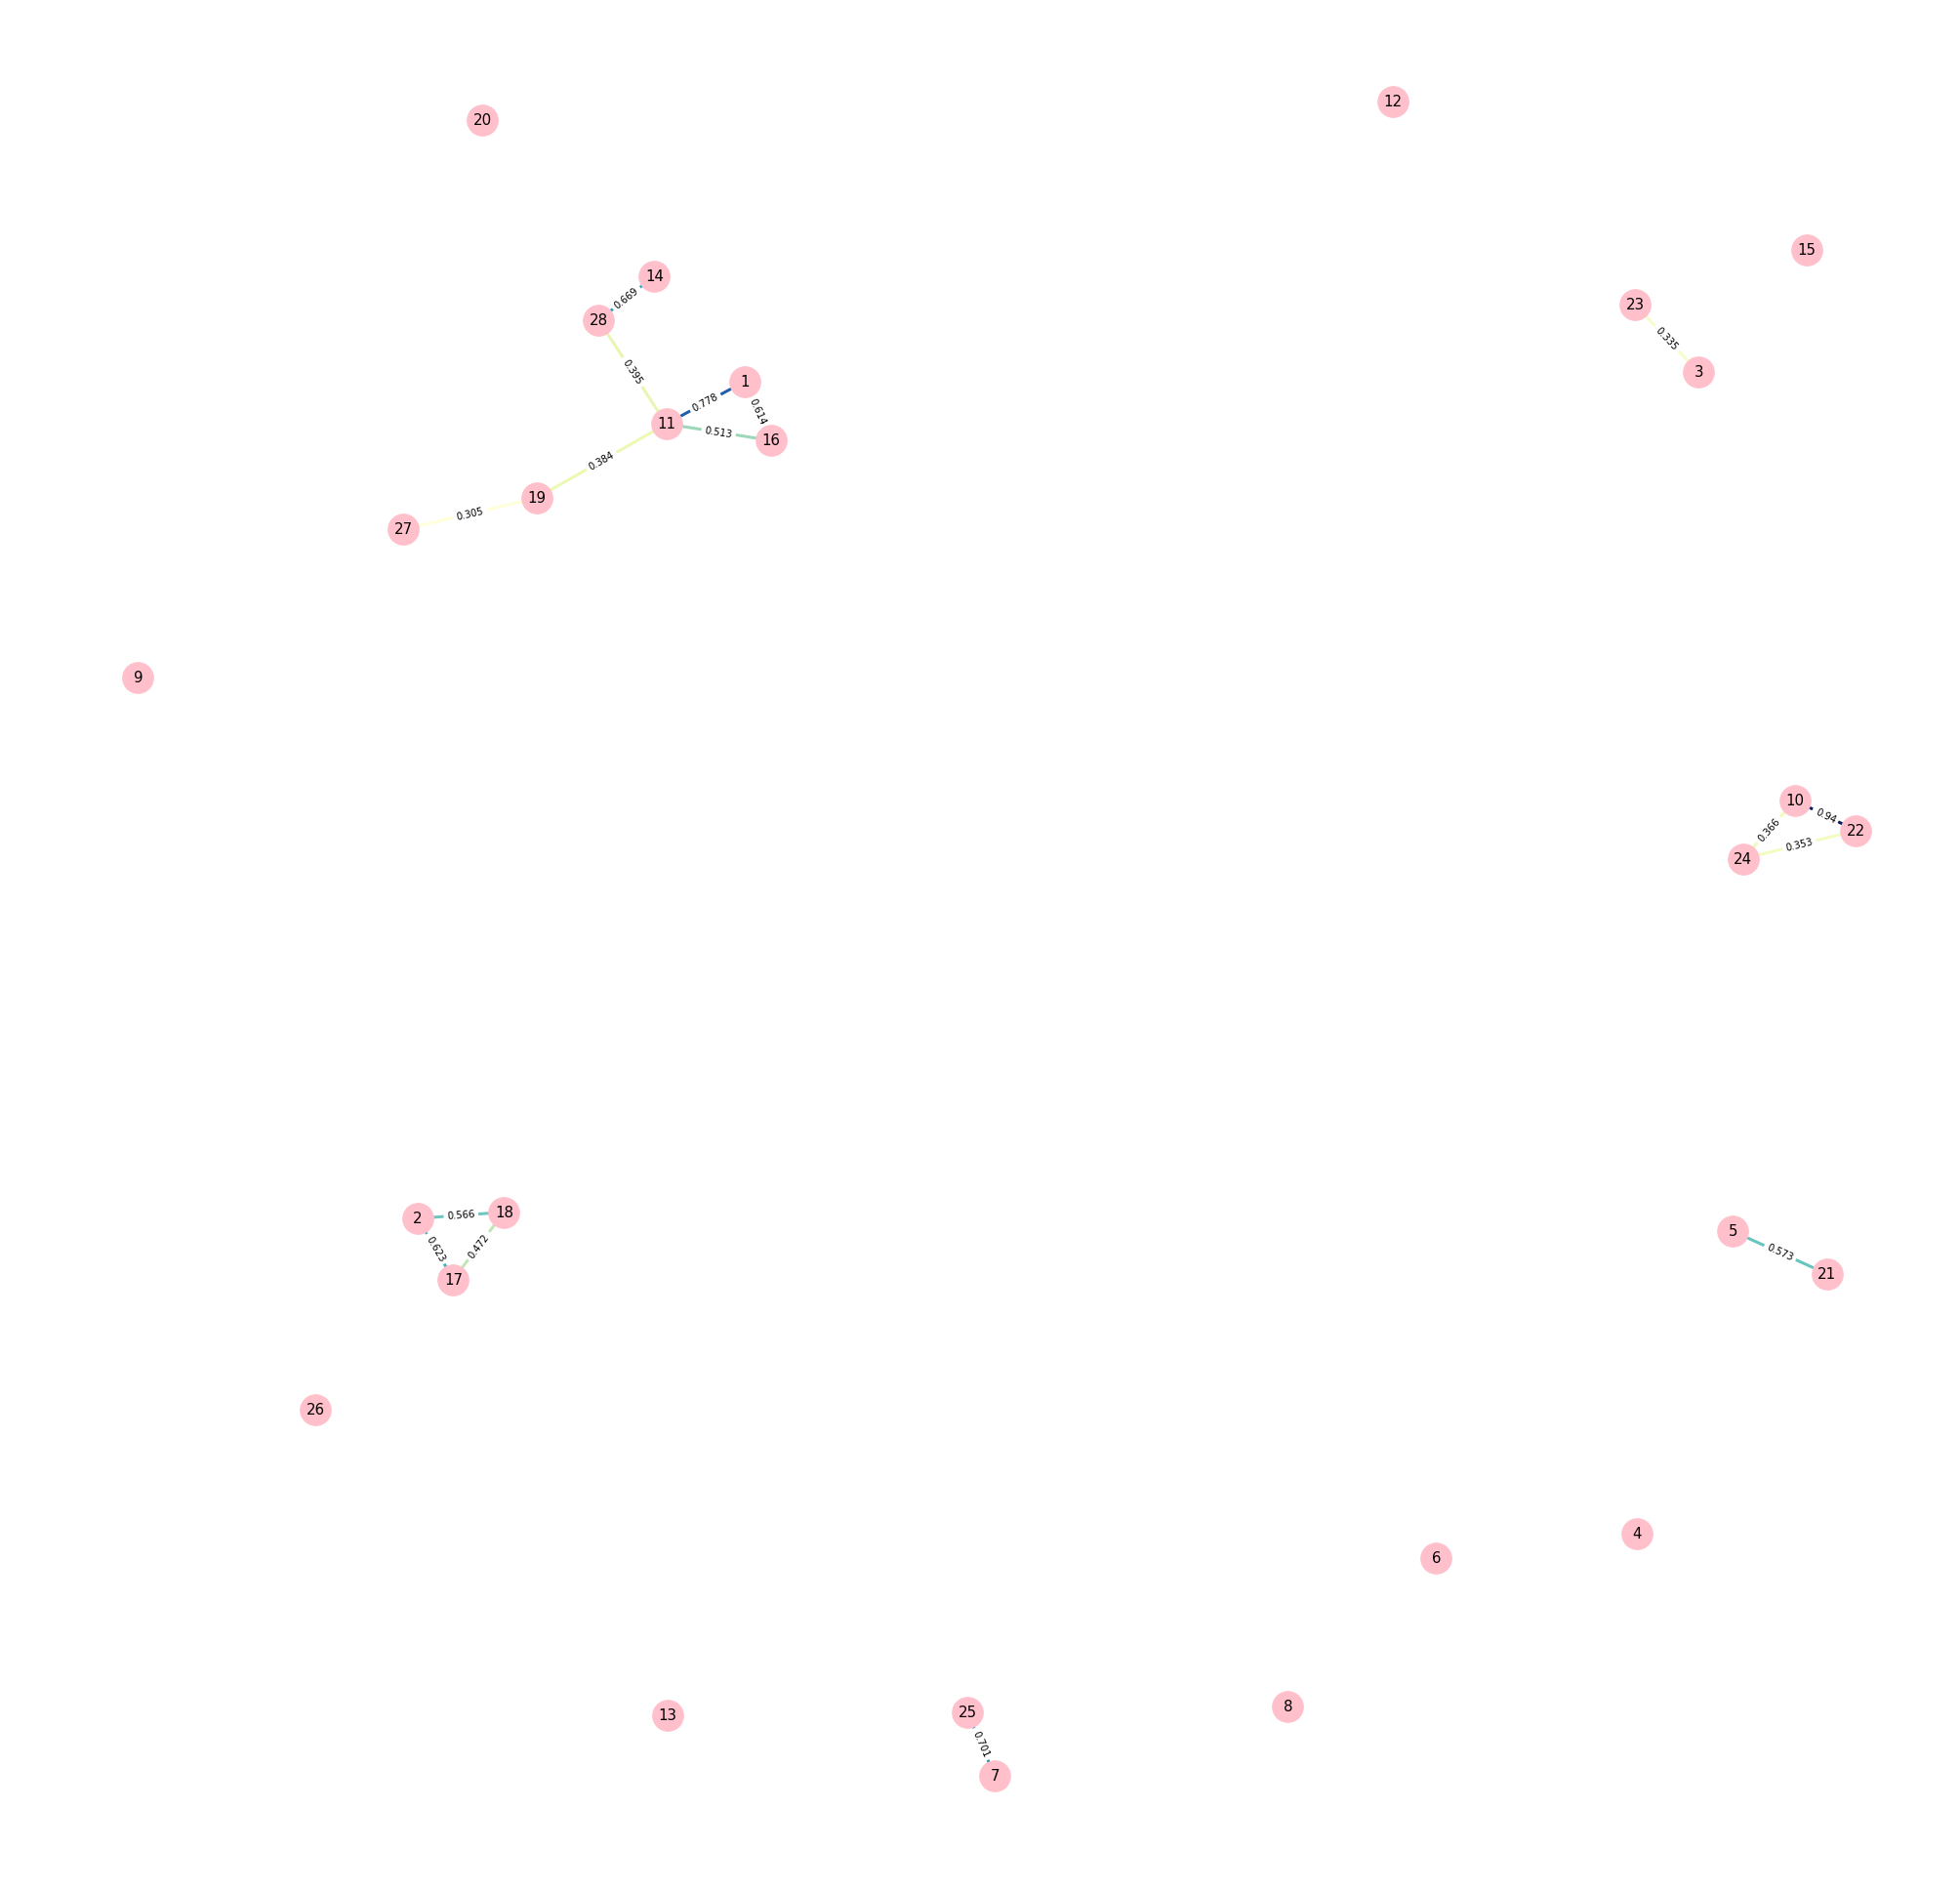

In [8]:
closed_arms_indices = drd73_fe.neuron_concated_behavior.loc[drd73_fe.neuron_concated_behavior["ClosedArms_centerpoint"] != 0].index
drd73_closed_arms_graph = NeuronNetwork(drd73_fe.cell_transients_df.iloc[closed_arms_indices])
drd73_closed_arms_graph.plot(node_color="pink", figsize=(35, 35), node_size=1000)

# Now we compute and plot all of the network measures (of interest), for each mouse.

In [9]:
def get_behavior_graphs(feature_extractors, behavior):
    graphs = list()
    
    for fe_obj in feature_extractors:
        indices = fe_obj.neuron_concated_behavior.loc[fe_obj.neuron_concated_behavior[behavior] != 0].index
        graph = NeuronNetwork(fe_obj.cell_transients_df.iloc[indices])
        graphs.append(graph)
        
    return graphs

In [10]:
import plotly
import plotly.graph_objs as go

def plot_network_measures(y, y2, *animal_names, **kwargs):
    trace1 = go.Bar(
        x=animal_names,
        y=y,
        text=y,
        textposition = "auto",
        name="Open Arms",
        marker=dict(color="rgb(255, 0, 0)"),
        opacity=0.6
    )
    trace2 = go.Bar(
        x=animal_names,
        y=y2,
        text=y2,
        textposition = "auto",
        name="Closed Arms",
        marker=dict(color="rgb(58,200,225)"),
        opacity=0.6
    )
    data = [trace1, trace2]
    layout = go.Layout(
        title = kwargs["title"],
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

### *Hubs are nodes with high degree, or high centrality. The centrality of a node measures how many of the shortest paths between all other nodes pairs in the network pass through it. A node with high centrality is thus cruciail to efficinet communication.* (Bullmore and Sporns)

### We took take the mean of the degree centrality of all the nodes in the networks of interest. As we can see, the mean degree centrality of the networks is higher when the mice were in the open arms of the EPM.

In [11]:
feature_extractors = [drd73_fe]

In [12]:
open_arms_graphs = get_behavior_graphs(feature_extractors, "OpenArms_centerpoint")

open_measures = list()
for open_arms_graph in open_arms_graphs:
    open_measures.append(open_arms_graph.mean_degree_centrality)    
    
closed_arms_graphs = get_behavior_graphs(feature_extractors, "ClosedArms_centerpoint")

closed_measures = list()
for closed_arms_graph in closed_arms_graphs:
    closed_measures.append(closed_arms_graph.mean_degree_centrality) 

x_axis = ["DRD73"]
plot_network_measures(open_measures, closed_measures, *x_axis, title="Mean Degree Centrality")

### *Connection density is the actual number of edges in the graph as a proportion of the total number of possible edges and is the simplest estimator of the physical cost — for example, the energy or other resource requirements — of a network.* (Bullmore and Sporns)

### As one would expect, the connection density is greater when the mice were in the open arms of the EPM.

In [13]:
open_arms_graphs = get_behavior_graphs(feature_extractors, "OpenArms_centerpoint")

open_measures = list()
for open_arms_graph in open_arms_graphs:
    open_measures.append(open_arms_graph.connection_density)    
    
closed_arms_graphs = get_behavior_graphs(feature_extractors, "ClosedArms_centerpoint")

closed_measures = list()
for closed_arms_graph in closed_arms_graphs:
    closed_measures.append(closed_arms_graph.connection_density) 

plot_network_measures(open_measures, closed_measures, *x_axis, title="Connection Density")

### *If the nearest neighbors of a node are also directly connected to each other they form a cluster. The clustering coefficient quantifies the number of connections that exist between the nearest neighbors of a node as a proportion of the maximum number of possible connections. Random networks have lowe average clustering whereas complex networks have high clustering (associated with high local efficiency of information transfer and robustness).* (Bullmore and Sporns)

### As shown below, the clustering coefficient for all the networks was greater when the mice were in the open arms of the EPM.

In [14]:
open_arms_graphs = get_behavior_graphs(feature_extractors, "OpenArms_centerpoint")

open_measures = list()
for open_arms_graph in open_arms_graphs:
    open_measures.append(open_arms_graph.clustering_coefficient)    
    
closed_arms_graphs = get_behavior_graphs(feature_extractors, "ClosedArms_centerpoint")

closed_measures = list()
for closed_arms_graph in closed_arms_graphs:
    closed_measures.append(closed_arms_graph.clustering_coefficient) 

plot_network_measures(open_measures, closed_measures, *x_axis, title="Clustering Coefficient")

### *The 'small-world' property combines high levels of local clustering among nodes of a network (to form families or cliques) and short paths that globally link all nodes of a network. This means that all nodes of a large system are linked through relatively few intermediate steps, despite the fact that most nodes maintain only a few direct connections - mostly within a clique of neighbours.* (Bullmore and Sporns)

### As shown below, we computed the mean clique size, as well as the maximum clique size, in all networks of interest. We observe that larger cliques of neurons were formed when the mice were in the open arms of the EPM.

In [15]:
open_arms_graphs = get_behavior_graphs(feature_extractors, "OpenArms_centerpoint")

open_measures = list()
for open_arms_graph in open_arms_graphs:
    open_measures.append(open_arms_graph.mean_clique_size)    
    
closed_arms_graphs = get_behavior_graphs(feature_extractors, "ClosedArms_centerpoint")

closed_measures = list()
for closed_arms_graph in closed_arms_graphs:
    closed_measures.append(closed_arms_graph.mean_clique_size)
    
plot_network_measures(open_measures, closed_measures, *x_axis, title="Mean Clique Size")

In [16]:
open_arms_graphs = get_behavior_graphs(feature_extractors, "OpenArms_centerpoint")

open_measures = list()
for open_arms_graph in open_arms_graphs:
    open_measures.append(open_arms_graph.max_clique_size)    
    
closed_arms_graphs = get_behavior_graphs(feature_extractors, "ClosedArms_centerpoint")

closed_measures = list()
for closed_arms_graph in closed_arms_graphs:
    closed_measures.append(closed_arms_graph.max_clique_size)
    
plot_network_measures(open_measures, closed_measures, *x_axis, title="Max Clique Size")

### *Path length is the minimum number of edges that must be traversed to go from one node to another. Random and complex networks have short mean path lengths (high global efficiency of parallel information transfer) whereas regular lattices have long mean path lengths. Efficiency is inversely related to path length but is numerically easier to use to estimate topological distances between elements of disconnected graphs.* (Bullmore and Sporns)

### We compute the global efficiency of all networks of interest, and we find that global efficiency was greater when the mice were in the open arms of the EPM.

In [17]:
open_arms_graphs = get_behavior_graphs(feature_extractors, "OpenArms_centerpoint")

open_measures = list()
for open_arms_graph in open_arms_graphs:
    open_measures.append(open_arms_graph.global_efficiency)    
    
closed_arms_graphs = get_behavior_graphs(feature_extractors, "ClosedArms_centerpoint")

closed_measures = list()
for closed_arms_graph in closed_arms_graphs:
    closed_measures.append(closed_arms_graph.global_efficiency)
    
plot_network_measures(open_measures, closed_measures, *x_axis, title="Global Efficiency")

In [18]:
open_arms_graphs = get_behavior_graphs(feature_extractors, "OpenArms_centerpoint")

open_measures = list()
for open_arms_graph in open_arms_graphs:
    open_measures.append(open_arms_graph.mean_betw_centrality)    
    
closed_arms_graphs = get_behavior_graphs(feature_extractors, "ClosedArms_centerpoint")

closed_measures = list()
for closed_arms_graph in closed_arms_graphs:
    closed_measures.append(closed_arms_graph.mean_betw_centrality)
    
plot_network_measures(open_measures, closed_measures, *x_axis, title="Mean Betweeness Centrality")

In [19]:
def bin_by_time(dataframe, **kwargs):
    """Split dataframe by frequency
    
    Split up the time series data into specified time bins. 
    
    Args: 
        dataframe: DataFrame
        
            a pandas DataFrame of the signal data for 
            all the imaged neurons of a given animal activity.
        
        freq: string, optional
            
            If specified, this is the frequency by which the 
            passed DataFrame will be split. The default is 
            1Min.
    
    Returns: 
        time_bins: dictionary
            
            All of the DataFrames that encompasse the passed-in
            DataFrame.
    """
    
    # Create copy of the dataframe for a certain behavior
    time_binned_df = dataframe.copy()
    time_binned_df.reset_index(drop=True, inplace=True)
    
    # Add a column of the trial time in the form of time deltas
    x = pd.to_timedelta("0.1s")
    time_binned_df.loc[:, "TIME"] = pd.Series(x*i for i in (time_binned_df.index))
    
    # Group the dataframe by 1 minute intervals
    grouped = time_binned_df.set_index("TIME").groupby(pd.Grouper(freq=kwargs.get("freq", "1Min")))
    
    # Place each dataframe that contains the data for every 1 minute intervals into a dictionary
    time_bins = {}
    freq = 0
    for name, group in grouped:
        time_bins[freq] = grouped.get_group(name)
        freq += 1
        
    return time_bins

In [20]:
import networkx as nx

def get_continuous_beh_dataframes(neuron_network_obj, behavior, **kwargs):
    num_of_sec = kwargs.get("seconds", 5)
    framerate = kwargs.get("framerate", 10)
    dataframes = list()
    
    continuous_beh = dict()
    for row in neuron_network_obj.neuron_concated_behavior.itertuples():
        if getattr(row, behavior) == 1:
            continuous_beh[row[0]] = 1
        else:
            if len(continuous_beh) >= num_of_sec*framerate:
                
                # Note the start frame, and the end frame for when the animal entered the area.
                begin = list(continuous_beh.keys())[0]
                end = list(continuous_beh.keys())[len(list(continuous_beh.keys()))-1]
                print("Frames spent in behavior: {}:{}".format(begin, end))
                
                dataframe = cell_transients_dataframe.iloc[begin:end+1]
                dataframes.append(dataframe)

                continuous_beh.clear()
            else:
                continuous_beh.clear()
                
    return dataframes

In [21]:
open_arms_dataframes = get_continuous_beh_dataframes(drd73_fe, "OpenArms_centerpoint", seconds=2)
closed_arms_dataframes = get_continuous_beh_dataframes(drd73_fe, "ClosedArms_centerpoint", seconds=2)

Frames spent in behavior: 1369:1409
Frames spent in behavior: 2166:2254
Frames spent in behavior: 4889:4916
Frames spent in behavior: 5152:5207
Frames spent in behavior: 0:138
Frames spent in behavior: 170:250
Frames spent in behavior: 326:375
Frames spent in behavior: 472:524
Frames spent in behavior: 554:641
Frames spent in behavior: 784:850
Frames spent in behavior: 894:969
Frames spent in behavior: 975:1032
Frames spent in behavior: 1092:1161
Frames spent in behavior: 1222:1346
Frames spent in behavior: 1466:1599
Frames spent in behavior: 1650:1771
Frames spent in behavior: 1782:1930
Frames spent in behavior: 1971:2113
Frames spent in behavior: 2262:2336
Frames spent in behavior: 2348:2545
Frames spent in behavior: 2560:2786
Frames spent in behavior: 2984:3075
Frames spent in behavior: 3078:4111
Frames spent in behavior: 4173:4306
Frames spent in behavior: 4361:4590
Frames spent in behavior: 4652:4842
Frames spent in behavior: 4963:5126
Frames spent in behavior: 5285:5528
Frames sp

In [22]:
def sort_graphs_chronological(feature_extractor, open_arms_dataframes, closed_arms_dataframes):
    i = 0
    j = 0
    graph_measures = list()
    markers_on = list()

    while i < len(open_arms_dataframes):
        if open_arms_dataframes[i].index.values[-1] < closed_arms_dataframes[j].index.values[-1]:
            graph = NeuronNetwork(open_arms_dataframes[i])
            graph_measures.append(graph.mean_degree_centrality)
            markers_on.append(len(graph_measures)-1)
            i += 1
        else:
            graph = NeuronNetwork(closed_arms_dataframes[j])
            graph_measures.append(graph.mean_degree_centrality)
            j += 1

    while j < len(closed_arms_dataframes):
        graph = NeuronNetwork(closed_arms_dataframes[j])
        graph_measures.append(graph.mean_degree_centrality)
        j += 1
    
    return graph_measures, markers_on

In [23]:
graph_measures, markers_on = sort_graphs_chronological(drd73_fe, open_arms_dataframes, closed_arms_dataframes)

In [24]:
import matplotlib.pyplot as plt

def quick_plot(y_axis, figsize, color="blue", title="Title Goes Here", markevery=None):
    plt.figure(figsize=figsize)
    plt.plot(y_axis, color=color, marker='o', linestyle="solid", linewidth=1, markersize=7, markevery=markevery)
    plt.xlabel("Entry")
    plt.ylabel("Mean Betweeness Centrality")
    plt.title(title)
    plt.grid(True)
    plt.show();

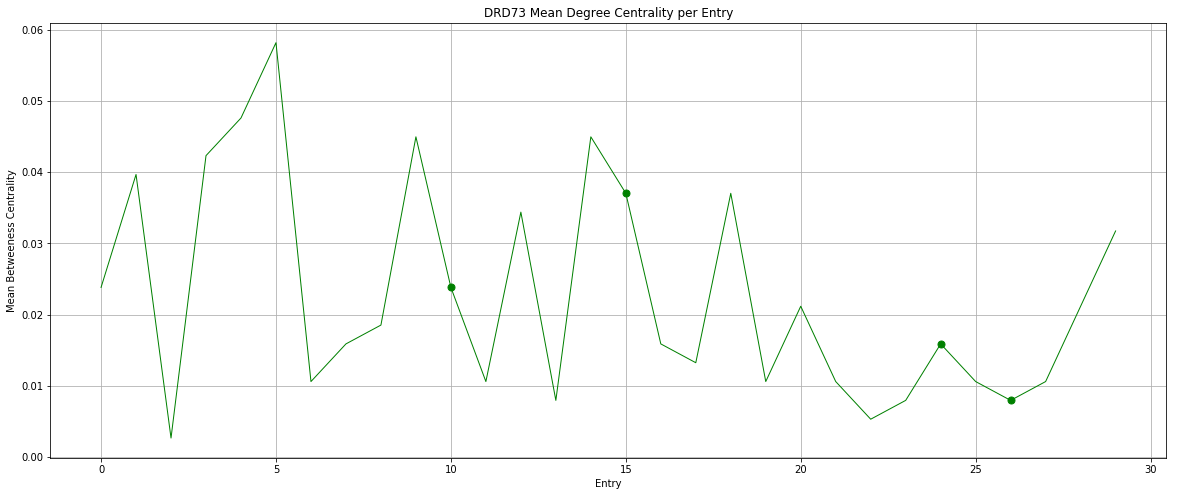

In [25]:
quick_plot(graph_measures, (20, 8), color="green", title="DRD73 Mean Degree Centrality per Entry", markevery=markers_on)